# Results
In this notebook, we define and calculate the statistics of our tests.

In [56]:
# load gold standard

import json
import pandas as pd
fileName = "gs.json"
goldStandard = {}

with open(fileName,'r',encoding='utf-8') as file:
    data = json.load(file)
    goldStandardRaw = {id: case["gs"] for id, case in data.items()}

for caseId, case in goldStandardRaw.items():
    goldStandard[caseId] = pd.Series(gs.replace("$","") for gs in case)
    
goldStandard['191']


0    onychomycosis
1      tinea pedis
2        psoriasis
dtype: object

In [57]:
# load results

import json
import pandas as pd
from collections import defaultdict
# fileName = "CaseReviewTest-2021-11-09 (2).json"
fileName = "experiments/experiments.json"
results = {}

with open(fileName, 'r', encoding='utf-8') as file:
    data = json.load(file)
    resultsCollected = defaultdict(lambda: dict())
    for test in data:
        resultsCollected[test["case_number"]][test["app"]] = \
            [result.strip().lower() for result in test["content"].split(";")]

    resultsNormalized = defaultdict(lambda: {})
    for caseId, result in resultsCollected.items():
        maxSize = max(max(len(ddx) for ddx in result.values()), len(goldStandard[caseId]))
        for app, ddx in result.items():
            resultsNormalized[caseId][app] = ddx + \
                [None] * (maxSize - len(ddx))

for caseId, case in resultsNormalized.items():
    results[caseId] = pd.DataFrame(case, columns=sorted(case.keys()))

list(results.items())[0]



('10',
                    AveyNormal              fullListConfAgeSort  \
 0          acute appendicitis               acute appendicitis   
 1              diverticulitis        acute mesenteric ischemia   
 2   acute mesenteric ischemia                   diverticulitis   
 3         acute cholecystitis              acute cholecystitis   
 4           acute cholangitis                acute cholangitis   
 5                        None                   cholelithiasis   
 6                        None             peptic ulcer disease   
 7                        None          small bowel obstruction   
 8                        None               acute pancreatitis   
 9                        None                   pyelonephritis   
 10                       None        cronkhite canada syndrome   
 11                       None                  nephrolithiasis   
 12                       None                   food poisoning   
 13                       None                  viral h

In [58]:
results['191']

,AveyNormal,fullListConfAgeSort,full_list
0,onychomycosis,onychomycosis,onychomycosis
1,None,cronkhite canada syndrome,cronkhite canada syndrome
2,None,None,None


In [59]:
# append cold standard to case
cases = dict()
for caseId, gs in goldStandard.items():
    if caseId in results:
        cases[caseId] = pd.DataFrame(results[caseId])
        cases[caseId].insert(loc=0, column="gs", value=gs)
cases['191']


,gs,AveyNormal,fullListConfAgeSort,full_list
0,onychomycosis,onychomycosis,onychomycosis,onychomycosis
1,tinea pedis,None,cronkhite canada syndrome,cronkhite canada syndrome
2,psoriasis,None,None,None


In [60]:
cases['195']

,gs,AveyNormal,fullListConfAgeSort,full_list
0,irritable bowel syndrome,irritable bowel syndrome,irritable bowel syndrome,irritable bowel syndrome
1,pelvic inflammatory disease,diverticulitis,ectopic pregnancy,diverticulitis
2,hypothyroidism,ovarian cancer,molar pregnancy,ovarian cancer
3,NaN,endometriosis,diverticulitis,endometriosis
4,NaN,ectopic pregnancy,ovarian cancer,ectopic pregnancy
5,NaN,pelvic inflammatory disease,pelvic inflammatory disease,pelvic inflammatory disease
6,NaN,None,spontaneous abortion,inflammatory bowel disease
7,NaN,None,endometriosis,secondary dysmenorrhea
8,NaN,None,cystitis,colonic polyps
9,NaN,None,chlamydia,lactose intolerance


## Let us define the metrics now.

### Terms used
- TP: True positive
- TN: True negative
- FP: False positive
- FN: False negative

### Precision
$$precision = \frac{TP}{TP + FP} = \frac{TP}{\text{length of differential list}}$$

### Recall
$$recall = \frac{TP}{TP + FN} = \frac{TP}{\text{length of the gold standard}}$$

### F1 Score
Suppose $\beta$ defines how important is $recall$ to $precision$ then,
$$fscore_{\beta} = (1 + \beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$
Substituting $\beta = 1$,
$$fscore_{1} = \frac{2 \cdot precision \cdot recall}{ precision + recall}$$

### NDCG
NDCG or Normalized Discounted Cumulative Gain is measure of how accurate the ranking is. In our calculations, we use
$$DCG = \sum_{i=1}^n\frac{2^{relevance_i}-1}{log_2(i+1)}$$
where $n$ is the number of differentials in the returned list and  
$relevance_i = |gold standard| - rank_{gold\ standard}(ddx[i])$ if $ddx[i]$ is present, 0 otherwise.

$$NDCG = \frac{DCG_{ddx}}{DCG_{gold\ standard}}$$

### M Score
M Score determines where the top disease (gold standard) appears in the returned differential.
$$M_i = \text{gold standard[0]} \in \text{ddx[:i]}$$

### Position
Shows the position of the gold standard[0] in the returned differential. 

### Length
$$length = \frac{|ddx|}{|gold\ standard|}$$


In [61]:
import math


def getPrecision(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp if tp == 0 else tp/candidate.count()


def getRecall(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp/goldStandard.count()


def getF1Score(precision: float, recall: float) -> float:
    return math.nan if precision+recall == 0 else 2*precision*recall/(precision+recall)


def getNDCG(goldStandard: pd.Series, candidate: pd.Series, scores) -> float:
    def discount(score: float, index: int) -> float:
        return (math.pow(2, score)-1)/math.log2(index+1)
        # return (math.pow(2,score)-1)/math.log2(index+1)

    maxDCG = sum(discount(scores[i], i+1) for i in range(len(scores)))

    candidateRelevance = []
    for index, disease in enumerate(candidate):
        goldStandard = list(goldStandard)
        if disease is not None and disease in goldStandard:
            candidateRelevance.append(
                discount(scores[goldStandard.index(disease)], index+1))
        else:
            candidateRelevance.append(0)

    return sum(candidateRelevance)/maxDCG


def getMScore(goldStandard: pd.Series, candidate: pd.Series, m=1) -> bool:
    return goldStandard.values[0] in candidate.values[:m]


def getPosition(goldStandard: pd.Series, candidate: pd.Series) -> bool:
    return math.nan if goldStandard.values[0] not in candidate.values else 1 + list(candidate.values).index(goldStandard.values[0])


def getLength(goldStandard: pd.Series, candidate: pd.Series) -> int:
    return math.nan if candidate.count() == 0 else candidate.count()/goldStandard.count()


def getScoresCase(case: pd.DataFrame) -> pd.DataFrame:
    scores = [
        [getPrecision(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))],
        [getRecall(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))]
    ]

    scores.append([getF1Score(scores[0][i], scores[1][i])
                  for i in range(len(case.columns)-1)])
    scores.append([getNDCG(case.iloc[:, 0], case.iloc[:, i], list(range(case.iloc[:, 0].count(), 0, -1)))
                  for i in range(1, len(case.columns))])

    for m in range(1, 6, 2):
        scores.append([getMScore(case.iloc[:, 0], case.iloc[:, i], m)
                      for i in range(1, len(case.columns))])

    scores.append([getPosition(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    scores.append([getLength(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    return pd.DataFrame(scores, columns=case.columns[1:],
                        index=["precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"])


# calculate all scores
scores = {id: getScoresCase(case) for id, case in cases.items()}
scores

recall = sorted([(id,c.loc["recall","full_list"]) for id, c in scores.items() ],key=lambda x : x[1])

recall


[('64', 0.0),
 ('191', 0.3333333333333333),
 ('27', 0.3333333333333333),
 ('197', 0.5),
 ('138', 0.5),
 ('198', 0.6666666666666666),
 ('196', 0.6666666666666666),
 ('195', 0.6666666666666666),
 ('181', 0.6666666666666666),
 ('173', 0.6666666666666666),
 ('118', 0.6666666666666666),
 ('112', 0.6666666666666666),
 ('82', 0.6666666666666666),
 ('65', 0.6666666666666666),
 ('37', 0.6666666666666666),
 ('35', 0.6666666666666666),
 ('25', 0.6666666666666666),
 ('19', 0.6666666666666666),
 ('9', 0.6666666666666666),
 ('44', 0.75),
 ('20', 0.75),
 ('104', 0.8),
 ('200', 1.0),
 ('199', 1.0),
 ('194', 1.0),
 ('193', 1.0),
 ('192', 1.0),
 ('190', 1.0),
 ('189', 1.0),
 ('188', 1.0),
 ('187', 1.0),
 ('186', 1.0),
 ('185', 1.0),
 ('184', 1.0),
 ('183', 1.0),
 ('182', 1.0),
 ('180', 1.0),
 ('179', 1.0),
 ('178', 1.0),
 ('176', 1.0),
 ('174', 1.0),
 ('172', 1.0),
 ('171', 1.0),
 ('170', 1.0),
 ('169', 1.0),
 ('168', 1.0),
 ('167', 1.0),
 ('166', 1.0),
 ('165', 1.0),
 ('164', 1.0),
 ('163', 1.0),
 ('16

In [62]:
def getAverage(scores, row: int, col: int) -> float:
    values = []
    for id, score in scores.items():
        if not math.isnan(score.iloc[row, col]):
            values.append(score.iloc[row, col])

    return 0 if not values else round(sum(values)/len(values), 3)


averageScores = pd.DataFrame(
    [
        [
            getAverage(scores, row, col)
            for col in range(len(next(iter(scores.values())).columns))
        ]
        for row in range(9)
    ],
    columns=next(iter(scores.values())).columns,
    index=[
        f"average_{x}" for x in [
            "precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"
        ]
    ]
)

#ignore nan for recall
for col in next(iter(scores.values())).columns:
    p = averageScores.loc["average_precision", col]
    r = averageScores.loc["average_recall", col]
    averageScores.loc["average_f1-score", col] = round(2*p*r/(p+r), 3)

averageScores


,AveyNormal,fullListConfAgeSort,full_list
average_precision,0.439,0.158,0.158
average_recall,0.696,0.913,0.913
average_f1-score,0.538,0.269,0.269
average_NDCG,0.772,0.820,0.818
average_M1,0.720,0.710,0.720
average_M3,0.930,0.930,0.930
average_M5,0.940,0.940,0.950
average_position,1.358,1.838,1.808
average_length,1.895,13.763,13.763


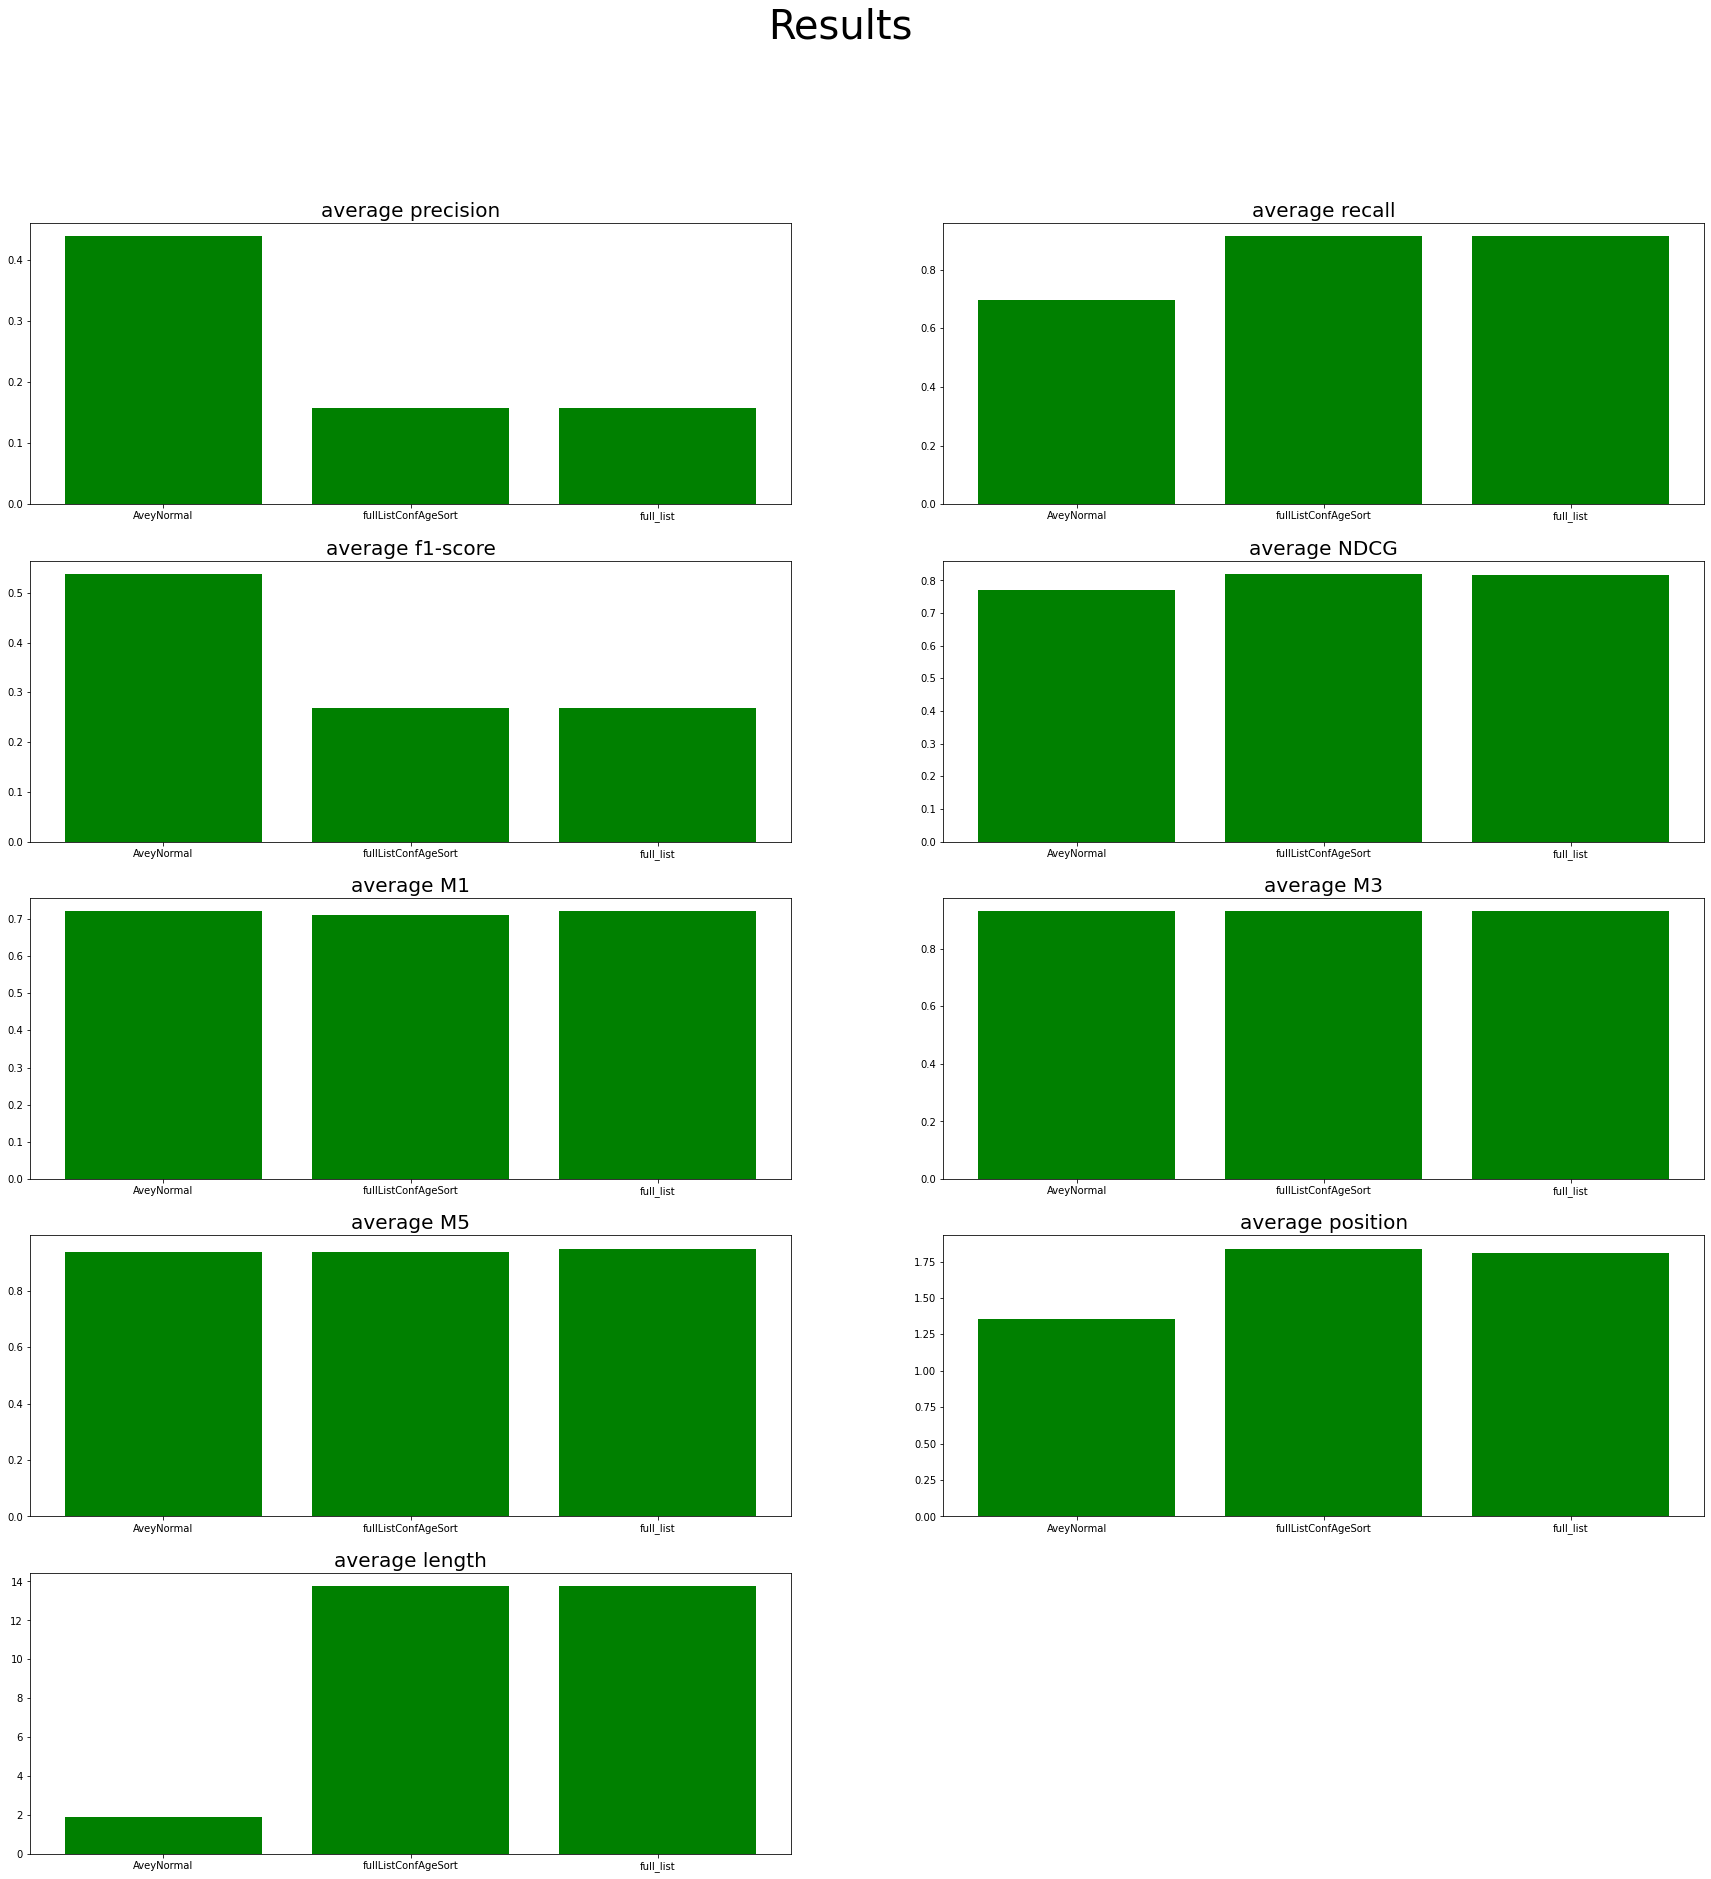

In [63]:
import matplotlib.pyplot as plt
import math

scoresToCompare = pd.DataFrame(averageScores,columns=averageScores.columns)

fig, subplots = plt.subplots(5,2, figsize=(30,30))
fig.suptitle("Results",fontsize=40)

for index, metric in enumerate(scoresToCompare.index.values.tolist()):
    subplots[index//2, index %
             2].bar(scoresToCompare.columns, averageScores.loc[metric],color="green")
    subplots[index//2, index % 2].set_title(metric.replace("_"," "),fontsize=20)


fig.delaxes(subplots[4,1])
plt.show()
